# annotation

> Pipeline to annotate peptides


In [ ]:
#| default_exp annotation

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
from typing import Dict, Union
from pyteomics import parser
from pyteomics import mass
from pathlib import Path
from Bio import SeqIO
import pandas as pd
from protein_cutter.core import digest_to_empai_set
from protein_cutter.core import collapse_empai_entries
from protein_cutter.core import flag_proprietary_peptides_from_set
from protein_cutter.core import flag_proprietary_from_pg
from protein_cutter.core import load_peptides_from_fasta
from protein_cutter.core import load_fasta

In [ ]:
#| export
from pathlib import Path
import os
import yaml
# Get the repository root
if 'GITHUB_WORKSPACE' in os.environ:
    # In GitHub Actions
    REPO_ROOT = Path(os.environ['GITHUB_WORKSPACE'])
else:
    # Local development - find repo root
    REPO_ROOT = Path.cwd()
    while not (REPO_ROOT / 'settings.ini').exists():
        if REPO_ROOT == REPO_ROOT.parent:
            REPO_ROOT = Path.cwd()  # Fallback
            break
        REPO_ROOT = REPO_ROOT.parent

TEST_DATA = REPO_ROOT / 'test_data'
CONFIG_FILES = REPO_ROOT / 'config_files'
print(f"Repo root: {REPO_ROOT}")
print(f"Test data dir: {TEST_DATA}")
print(f"Test data exists: {TEST_DATA.exists()}")

Repo root: /Users/mtinti/git_projects/protein_cutter
Test data dir: /Users/mtinti/git_projects/protein_cutter/test_data
Test data exists: True


In [ ]:
with open(CONFIG_FILES / 'config.yaml', 'r') as stream:
    config = yaml.safe_load(stream)
print(config)   

{'canonical_fasta': 'test_sequence.fa', 'min_pep_length': 5, 'input_file': 'test_spectronaut_pep_out.tsv'}


In [ ]:
infile = TEST_DATA/'pipeline_test/prot.fa'
#infile = '../datasets/spectronaut_protein.fasta'
fasta_dict = load_fasta(infile)

/Users/mtinti/git_projects/protein_cutter/nbs


In [ ]:
fasta_dict

{'Tb427_000198100.1-p1': 'MSISESDSLWLQKSIHLADPIPEATGEGVETDENSRPGELLMVGEGMAKEVEELGGSSGPSSARFINSTSQRASCRQSVSNASFASLHEIDELRARIAQLKREQLRWSGNQRELEIVRFELVQIQQELQTTREYARTLKEQLDEAEAKAEKEAKARRNSEAQLEKSISQSSRDKEFLKQQLEAMKEEHCRQLAEVEGRSEVEGSGRTEFMREQITKLTEDI*ALDESNVKSREEACRLGRENELLRANIKSTQAKCEELQRSLESCTTRYAELENMHNIFVEKTERSKSEALDSLMATNNDRMKKIISSKEEIIDELHEELKVFKGKSGSFSEEITNLQHRVRMLEAEAKQMTQEHEKELRSIRDQHHLALCQQKQESEILIREAKNGRVSLEEETSFLKRQAVKAAEELSAAAALIVQREEQLSHLESEKITMRNALQAAERDRASAADKLETARSELLQAEERTQHLQQQYDLTETVYSQDMLELKEKLAAAQVKLMQTESELSAVRQEKMKYETEAITNMSDLRSKLEDAECDRKRLQHAVEQASQTDKQLEQLRVKYLTMCKRAENMEIELAAVTSRCSLLEKRLDEEFRRSVRNASHSPVSLHFGGGNVCLRGIQSANVPPSASKQAKRSRSVEQRVFTISGFDGTELLEKIHKLPYATVAECKSNSPVPTNLTHLVTNGQLTVKLLTALVRGCWILPEAYVHESTKQKMWLDELSYGFRHVKLPIARKRIGFSEGFVSSRHLNTANLIIVEGGATVESNLSEADMILCTRSEYGNMENTRAVTWDKLVELIYPVKIGVVAEEVKQPQ',
 'Tb427_000008800.1-p1': 'MTTSECYAPQLDLLMNSDHKEHVQRCYWFFNVGYRKEEDKKLPHLLKSPPTGKPYLSGGGLIARVWAFKKFEYAFGELLKGSEEWVRAEYLQTVVNMECNSGRSCWTEICFEERNDWIG'}

In [ ]:
def get_observable(sequence):
    observable_peptides = collapse_empai_entries(
    digest_to_empai_set(
        missed_cleavages = 0,
        enzyme = 'trypsin_full',
        mz_range=(100,4000),
        sequence=sequence
        
        )
    )
    return observable_peptides

In [ ]:
import polars as pl

In [ ]:
#infile = "../datasets/spectronaut_peptide_report.tsv"
infile = TEST_DATA/'pipeline_test/pep_report.tsv'
df_pep  = pl.read_csv(infile,separator='\t').to_pandas()
df_pep = df_pep[df_pep['PEP.NrOfMissedCleavages']==0]
df_pep.head()

,,R.Condition,R.FileName,R.Replicate,PG.ProteinAccessions,PG.ProteinDescriptions,PG.ProteinNames,PG.Coverage,PG.IsSingleHit,PG.Qvalue,PG.Quantity,PEP.IsProteotypic,PEP.NrOfMissedCleavages,PEP.StrippedSequence,EG.PrecursorId,EG.Identified,EG.Qvalue,EG.ApexRT,EG.TotalQuantity (Settings),FG.Charge
0,0,Cell-34C,331_2022_GBR-Cell-34C-A,1,Tb427_000008800.1-p1,transcript=Tb427_000008800.1 | gene=Tb427_0000...,None,16.8%,False,0.0,551307.5625,False,0,MTTSECYAPQLDLLMNSDHK,_MTTSEC[Carbamidomethyl (C)]YAPQLDLLMNSDHK_.3,True,4.721150e-27,86.696732,1.350588e+06,3
1,1,Cell-34C,331_2022_GBR-Cell-34C-A,1,Tb427_000008800.1-p1,transcript=Tb427_000008800.1 | gene=Tb427_0000...,None,16.8%,False,0.0,551307.5625,False,0,MTTSECYAPQLDLLMNSDHK,_M[Oxidation (M)]TTSEC[Carbamidomethyl (C)]YAP...,True,1.694105e-28,86.696732,1.334962e+06,3
2,2,Cell-34C,331_2022_GBR-Cell-34C-A,1,Tb427_000008800.1-p1,transcript=Tb427_000008800.1 | gene=Tb427_0000...,None,16.8%,False,0.0,551307.5625,False,0,MTTSECYAPQLDLLMNSDHK,_MTTSEC[Carbamidomethyl (C)]YAPQLDLLM[Oxidatio...,True,5.703590e-22,86.686089,3.219499e+05,3
3,3,Cell-34C,331_2022_GBR-Cell-34C-A,1,Tb427_000008800.1-p1,transcript=Tb427_000008800.1 | gene=Tb427_0000...,None,16.8%,False,0.0,551307.5625,False,0,MTTSECYAPQLDLLMNSDHK,_MTTSEC[Carbamidomethyl (C)]YAPQLDLLMN[Deamida...,True,4.645979e-31,89.731918,8.812225e+04,3
4,4,Cell-34C,331_2022_GBR-Cell-34C-A,1,Tb427_000008800.1-p1,transcript=Tb427_000008800.1 | gene=Tb427_0000...,None,16.8%,False,0.0,551307.5625,False,0,MTTSECYAPQLDLLMNSDHK,_MTTSEC[Carbamidomethyl (C)]YAPQLDLLMNSDHK_.2,True,4.328258e-07,86.766289,5.902369e+04,2


In [ ]:
#infile = "../datasets/spectronaut_protein_report.tsv"
infile = TEST_DATA/'pipeline_test/prot_report.tsv'
df_prot = pl.read_csv(infile,separator='\t').to_pandas()
df_prot.head()

,,PG.ProteinGroups,[1] 331_2022_GBR-Cell-34C-A.raw.PG.Quantity,[2] 331_2022_GBR-Cell-34C-B.raw.PG.Quantity,[3] 331_2022_GBR-Cell-34C-C.raw.PG.Quantity,[4] 331_2022_GBR-Cell-37C-A.raw.PG.Quantity,[5] 331_2022_GBR-Cell-37C-B.raw.PG.Quantity,[6] 331_2022_GBR-Cell-37C-C.raw.PG.Quantity,[7] 331_2022_GBR-Cell-40C-A.raw.PG.Quantity,[8] 331_2022_GBR-Cell-40C-B.raw.PG.Quantity,[9] 331_2022_GBR-Cell-40C-C.raw.PG.Quantity,[10] 331_2022_GBR-SN-34C-A.raw.PG.Quantity,[11] 331_2022_GBR-SN-34C-B.raw.PG.Quantity,[12] 331_2022_GBR-SN-34C-C.raw.PG.Quantity,[13] 331_2022_GBR-SN-37C-A.raw.PG.Quantity,[14] 331_2022_GBR-SN-37C-B.raw.PG.Quantity,[15] 331_2022_GBR-SN-37C-C.raw.PG.Quantity,[16] 331_2022_GBR-SN-40C-A.raw.PG.Quantity,[17] 331_2022_GBR-SN-40C-B.raw.PG.Quantity,[18] 331_2022_GBR-SN-40C-C.raw.PG.Quantity
0,0,Tb427_000008800.1-p1,551307.562500,704164.562500,748118.875000,681518.625000,703385.687500,686961.1250,816417.812500,631893.750000,686818.437500,2.036847e+05,189815.296875,83305.46875,2.046948e+05,167546.3125,117179.421875,215901.4375,273887.625,135870.109375
1,29,Tb427_000198100.1-p1,17201.074219,22934.291016,24707.408203,20580.830078,23038.123047,24520.1875,29426.867188,28961.535156,100298.835938,1.619666e+06,787221.187500,106877.75000,1.162788e+06,311610.7500,151712.437500,565188.1875,584564.250,379278.843750


In [ ]:
from tqdm.auto import tqdm
a=0
pai_res = []
for pg in tqdm(df_prot['PG.ProteinGroups']):
    prot = pg.split(';')[0]
    seq = fasta_dict[prot]
    seq = seq.replace('*','')
    observable_peptide = get_observable(seq)
    observed_peptide = set(df_pep[df_pep['PG.ProteinAccessions']==pg]['PEP.StrippedSequence'].unique())
    for temp_pep in observed_peptide:
        if 'M'+temp_pep in observable_peptide:
            observable_peptide.add(temp_pep)
            
    #print(observable_peptide)
    #print(observed_peptide)
    pai = len(observed_peptide)/float(len(observable_peptide))
    pai_res.append(pai)
    if len(observed_peptide-observable_peptide) > 0:
        print (prot)
        print (fasta_dict[prot])
        print('observed_peptide-observable_peptide')
        print(observed_peptide-observable_peptide)
        print('observable_peptide')
        print(observable_peptide)
        print('observed_peptide')
        print(observed_peptide)
        a+=1
        if a>=10:
            break
        print('---------------------------\n\n') 

100%|███████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 72.93it/s]


<Axes: xlabel='mean_intensity', ylabel='pai'>

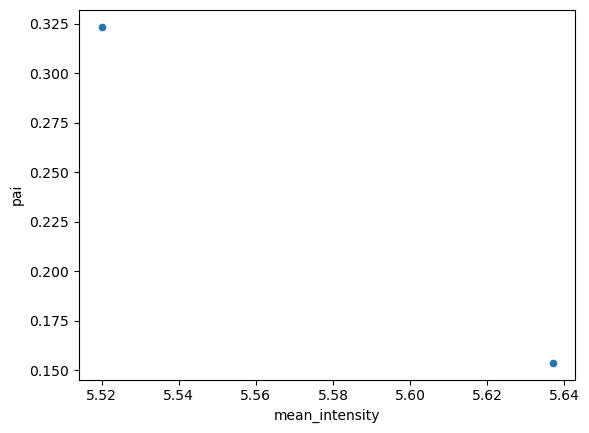

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
cols = [n for n in df_prot.columns if 'PG.Quantity' in n]
df_prot['mean_intensity']=np.log10(df_prot[cols].mean(axis=1,skipna=True))
df_prot['pai']=pai_res
df_prot.plot(kind='scatter',x='mean_intensity',y='pai',alpha=1)

In [ ]:
fasta_dict[prot]
'KCTNFGSIWNLR' in 'LGNEILYLESITITNYITFSVFKCNIPSR*RSK*HDKYDT*WY*ETQSLCGCCSNSCNTRMV*AHIECESKPCGNYYN*NGRFVQSFQKA*VGYGVFRETECK**GYFNS*GWI*CYSW*WK*V*EFCGIFCVKKHPTVRTIL*RGYSEKGYRVMLLIFEMATKVEEEKSTNSTKMAFNSKSI*MEVA*LPEFGHLRSLNMHLESY*REVRSGGQSRVFTNLC*YRVQFRKKLLDRDLF*REE*LDWITKRDFFL*KVVG*LEKPHSFIFLDSLLLGRRKRD*L*KILLI*KVERKRI*FEGYGENRNLSSRWREVG'

False

In [ ]:
#observed_peptide

In [ ]:
#observable_peptide,observed_peptide,observed_peptide-observable_peptide

In [ ]:
from pyteomics import parser
from pyteomics import mass

#cleavage_results = parser.xcleave(
#        fasta_dict['Tb427_000745700.1-p1'],
#        '[RK]',
#        missed_cleavages=0,
#        #exception=parser.expasy_rules['trypsin_exception'],
#    )
#cleavage_results

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()